<a href="https://colab.research.google.com/github/probabll/mixed-rv-vae/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#%load_ext autoreload
#%autoreload 2

On Colab, you will need to clone and install [probabll/dists.pt](https://github.com/probabll/dists.pt.git)

In [2]:
#!git clone https://github.com/probabll/dists.pt.git

In [3]:
#cd dists.pt

In [4]:
#!git pull

In [5]:
#pip install .

In [6]:
#cd ..

# Mixed RVs via Mixture of Dirichlets

In this notebook I develop a VAE whose latent code is a mixed rv on $\Delta_{K-1}$, that is, a sparse probability vector, via the so called *stratified representation*, that is, as a finite mixture of distributions on the faces of $K-1$-dimensional simplex.





## Stratified Representation


Let $Y$ be an rv taking on values in the simplex $\Delta_{K-1}$. The density assigned to an outcome $y \in \Delta_{K-1}$ is given by

\begin{align}
  p_{Y}(y|\alpha, \omega) &= \sum_{f} p_F(f|\omega) p_{Y|F}(y|f, \alpha) \\
  &= \sum_f \mathrm{Gibbs}(f|\omega) \mathrm{Dir}(y|\alpha_f)
\end{align}

where $f$ is a face of dimensionality $0 < \mathrm{dim}(f) < K -1$ and we choose a $(\mathrm{dim}(f)+1)$-dimensional Dirichlet distribution for $Y|F=f$. The simplex $\Delta_{K-1}$ has $2^K-1$ non-empty faces, each of which we represent by a $K$-dimensional vector $f \in \{0,1\}^K$ where $f_k$ indicates whether the vertex $\mathbf e_k$ is in the face. 

$F$ takes on values in the sample space $\mathcal F = \{0,1\}^K \setminus \{\mathbf 0_K\}$, and 

\begin{align}
p_{F}(f|\omega) &\propto \prod_{k=1}^K f_k \exp(\omega) + (1-f_k) \exp(-\omega)
\end{align}

The sample space $\mathcal F$ can be efficiently represented in a finite-state automaton of size $\mathcal O(K)$. As the unnormalised probability of any assignment $f$ factorises along the transitions of this automaton, the normalisation constant can be computed efficiently using the *value recursion* (or backward algorithm). Samples can be obtained with a linear pass through this automaton. Combining the value recursion and the *reverse value recursion* (forward algorithm), we can also compute the marginal probability $\Pr(F_k = 1)$ for any $k \in [K]$, as well as $\mathbb E[\psi(F)]$ for any function $\psi$ that factorises along $f_k$. One such function is surprisal $\log p_F(f|\omega)$, thus entropy, cross-entropy and KL divergence are available in closed-form. 

The parameters $\alpha_f \in \mathbb R_{>0}^{\mathrm{dim}(f)+1}$ can be shared across faces (or predicted via a shared parameterisation).

**Gradient estimation**

We assume samples from $Y|F=f, \alpha$ can be reparameterised in terms of samples from a fixed distribution $\Gamma$ independent of $\alpha$, i.e. $\gamma = \mathcal T^{-1}(y; \alpha_f) \sim \Gamma$, 
and use score function estimation for gradient estimation with respect to $\omega$:

\begin{align}
    \nabla_{\alpha,\omega} \mathbb E_{Y|\alpha, \omega}\left[ \psi(y) \right] &= \nabla_{\omega} \mathbb E_{F|\omega}\left[ \nabla_{\alpha} \mathbb E_{Y|F,\alpha} \left[ \psi(y) \right] \right] \\
    &= \mathbb E_{F|\omega}\left[ \left( \nabla_{\alpha} \mathbb E_{Y|F,\alpha} \left[ \psi(y) \right] \right)\nabla_{\omega} \log p_F(f) \right] \\
    &= \mathbb E_{F|\omega}\left[  \mathbb E_{} \left[ \nabla_{y} \psi(y) \nabla_{\alpha_f} \mathcal T(\gamma; \alpha_f) \right] \nabla_{\omega} \log p_F(f) \right]
\end{align}

For variance reduction we can use baselines based on summary statistics (e.g., mean, standard deviation), on trained MLPs, or based on $\nabla_{\alpha} \mathbb E_{Y|F,\alpha}[ \psi(y')]$ assessed at an additional sample $y'$ (this is known as  a self-critic). More sophisticated techniques are possible (but hopefully won't be needed).

In [7]:
import torch
torch.__version__

'1.8.1+cu102'

In [8]:
import numpy as np
import torch
import torch.distributions as td
import probabll.distributions as pd

# VAE

A variational auto-encoder approximates the distribution of $X$ on sample space $\mathcal X$ as a marginal of a joint distribution $X,Z|\theta$ whose pdf factorises $p_{XZ}(x, z|\theta) = p_{Z}(z|\theta)p_{X|Z}(x|z, \theta)$. Inference employs an independently parameterised  approximation $Z|X=x, \lambda$ to the true posterior distribution $Z|X=x, \theta$. The parameters $\theta$ of the generative model and $\lambda$ of the inference model are estimated jointly to maximise a lowerbound on the log-evidence (the ELBO):

\begin{align}
\theta^\star, \theta^\star &= \arg\,\max_{\theta, \lambda} ~ \sum_{x \sim \mathcal D}\mathrm{ELBO}_x(\theta, \lambda) \\
&= \arg\,\max_{\theta, \lambda} ~ \sum_{x \sim \mathcal D} \mathbb E_{Z|X,\lambda}\left[ \log \frac{p_{XZ}(x, z|\theta)}{q_{Z|X}(z|x, \lambda)} \right]
\end{align}

For us, $Z$ can be a $K$-dimensional mixed rv, a combination of an $H$-dimensional Gaussian embedding and a $K$-dimensional mixed rv, etc. In this notebook, an observed data point $x$ is an MNIST digit, i.e., $x\in \{0, 1\}^{D}$.

In [9]:
import torch.nn as nn


def assert_shape(t, shape, message):
    assert t.shape == shape, f"{message} has the wrong shape: got {t.shape}, expected {shape}"        


## Generative model

\begin{align}
p_{XYF}(x, y, f, z|\theta) &= p_Z(z)p_{F}(f)p_{Y|F}(y|f, \theta)p_{X|Y}(x|y, \theta) \\
&= \mathcal N(z|0, I_H) \times \mathrm{Gibbs}(f|\mathbf 0_K) \times \mathrm{Dir}(y|\mathbf 1_{\mathrm{dim}(f)+1}) \times \prod_{d=1}^D \mathrm{Bern}(x_d|b_d(y; \theta))
\end{align}

where the Gibbs distribution is constrained to supporting all but the empty face of $\Delta_{K-1}$, and $\mathbf b(x, y;\theta) \in (0,1)^D$ is the output of an NN with parameters $\theta$.


In [10]:
class GenerativeModel(nn.Module):

    def __init__(self, z_dim, y_dim, data_dim, hidden_dec_size, p_drop=0.0, prior_scores=0.0, prior_location=0.0, prior_scale=1.0):
        """
        :param z_dim: dimensionality (H) of the Gaussian rv (use 0 to disable it)
        :param y_dim: dimensionality (K) of the mixed rv
        :param data_dim: dimensionality (D) of the observation
        :oaram hidden_dec_size: hidden size of the decoder that parameterises X|Z=z, Y=y
        :param p_drop: dropout probability
        :param prior_scores: \omega in F|\omega 
            (float or K-dimensional tensor)
        :param prior_location: location of the Gaussian prior
            (float or H-dimensional tensor)
        :param prior_scale: scale of the Gaussian prior
            (float or H-dimensional tensor)
        """
        assert z_dim + y_dim > 0

        super().__init__()
        self._z_dim = z_dim
        self._y_dim = y_dim
        self._data_dim = data_dim   
        self._decoder = nn.Sequential(
            nn.Dropout(p_drop),
            nn.Linear(z_dim + y_dim, hidden_dec_size),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden_dec_size, hidden_dec_size),
            nn.ReLU(),
            nn.Dropout(p_drop),
            nn.Linear(hidden_dec_size, data_dim),
        )        
        self.register_buffer("_prior_scores", (torch.zeros(y_dim, requires_grad=False) + prior_scores).detach())
        self.register_buffer("_prior_location", (torch.zeros(z_dim, requires_grad=False) + prior_location).detach())
        self.register_buffer("_prior_scale", (torch.zeros(z_dim, requires_grad=False) + prior_scale).detach())

    @property
    def data_dim(self):
        return self._data_dim
    
    @property
    def latent_dim(self):
        return self._z_dim + self._y_dim
    
    @property
    def z_dim(self):
        return self._z_dim
    
    @property
    def y_dim(self):
        return self._y_dim
    
    def Z(self, predictors=None):
        """Return a Normal distribution over latent space"""
        Z = td.Normal(loc=self._prior_location, scale=self._prior_scale) if self._z_dim else pd.Delta(self._prior_location)
        return td.Independent(Z, 1)

    def F(self, predictors=None):
        """
        Return a distribution over the non-empty faces of the simplex
        :param predictors: input predictors, this is reserved for future use
        """
        if self._y_dim:
            return pd.NonEmptyBitVector(scores=self._prior_scores)
        else:
            return td.Independent(pd.Delta(self._prior_scores), 1)

    def Y(self, f, predictors=None):
        """
        Return a batch of masked Dirichlet distributions Y|F=f
        :param f: face-encoding [batch_size, K]
        :param predictors: input predictors, this is reserved for future use
        """
        if self._y_dim:
            return pd.MaskedDirichlet(f.bool(), torch.ones_like(f))
        else:
            return td.Independent(pd.Delta(torch.zeros_like(f)), 1)

    def X(self, z, y, predictors=None):
        """Return a product of D Bernoulli distributions"""
        if z.shape[:-1] != y.shape[:-1]:
            raise ValueError("z and y must have the same batch_shape")        
        inputs = torch.cat([z, y], -1)
        logits = self._decoder(inputs)
        return td.Independent(td.Bernoulli(logits=logits), 1)
    
    def sample(self, sample_shape=torch.Size([])):
        """Return (z, f, y, x)"""
        # [sample_shape, H]
        z = self.Z().sample(sample_shape)
        # [sample_shape, K]
        f = self.F().sample(sample_shape)
        # [sample_shape, K]
        y = self.Y(f=f).sample()
        # [sample_shape, D]
        x = self.X(z=z, y=y).sample()
        return z, f, y, x
    
    def log_prob(self, z, f, y, x, per_bit=False):
        """Return the log probability of each one of the variables"""
        if per_bit:
            return self.Z().log_prob(z), self.F().log_prob(f), self.Y(f).log_prob(y), self.X(z=z, y=y).base_dist.log_prob(x)
        else:
            return self.Z().log_prob(z), self.F().log_prob(f), self.Y(f).log_prob(y), self.X(z=z, y=y).log_prob(x)

## Inference model

\begin{align}
q_{ZFY|X}(z, f, y|x,\lambda) &= q_{Z|X}(z|x, \lambda)q_{F|X}(f|x, \lambda) q_{Y|FX}(y|f,x, \lambda) \\
&= \mathcal N(z|\mathbf u(x; \lambda), \mathbf v(x; \lambda)) \times \mathrm{Gibbs}(f|\mathbf s(x; \lambda)) \times \mathrm{Dir}(y|\mathbf a(x, f;\lambda))
\end{align}

where $\mathbf u(x; \lambda) \in \mathbb R^H$, $\mathbf v(x; \lambda) \in \mathbb R_{>0}^K$,  $\mathbf s(x; \lambda) \in \mathbb R^K$ and $\mathbf a(x, f; \lambda) \in \mathbb R_{>0}^{\mathrm{dim}(f)+1}$ are NN outputs; $\lambda$ denotes the NN parameters.

In [11]:
class InferenceModel(nn.Module):

    def __init__(self, z_dim, y_dim, data_dim, hidden_enc_size, cond='fx', p_drop=0.0):
        assert z_dim + y_dim > 0
        assert cond in {'f', 'x', 'fx'}, f"The concentration net can take 'f', 'x', or 'fx', got {cond}"
        super().__init__()

        self._cond = cond
        self._z_dim = z_dim
        self._y_dim = y_dim
        
        if z_dim: # TODO: share encoder across Z|x and F|x?
            self._gaussian_net = nn.Sequential(
                nn.Dropout(p_drop),
                nn.Linear(data_dim, hidden_enc_size),
                nn.ReLU(),
                nn.Dropout(p_drop),
                nn.Linear(hidden_enc_size, hidden_enc_size),
                nn.ReLU(),
                nn.Linear(hidden_enc_size, 2 * z_dim)
            )
        
        # Should F|x and/or Y|f,x also condition on z?
        if y_dim:
            self._scores_net = nn.Sequential(
                nn.Dropout(p_drop),
                nn.Linear(data_dim, hidden_enc_size),
                nn.ReLU(),
                nn.Dropout(p_drop),
                nn.Linear(hidden_enc_size, hidden_enc_size),
                nn.ReLU(),
                nn.Linear(hidden_enc_size, y_dim)
            )

            if cond == 'f':
                self._concentrations_net = nn.Sequential(
                    nn.Dropout(p_drop),
                    nn.Linear(y_dim, y_dim),
                    nn.ReLU(),
                    nn.Dropout(p_drop),
                    nn.Linear(y_dim // 2 + 1, y_dim // 2 + 1),
                    nn.ReLU(),
                    nn.Dropout(p_drop),
                    nn.Linear(y_dim // 2 + 1, y_dim),
                    nn.Softplus()
                )
            else: # x or fx
                self._concentrations_net = nn.Sequential(
                    nn.Dropout(p_drop),
                    nn.Linear(data_dim if cond == 'f' else y_dim + data_dim, hidden_enc_size),
                    nn.ReLU(),
                    nn.Dropout(p_drop),
                    nn.Linear(hidden_enc_size, hidden_enc_size),
                    nn.ReLU(),
                    nn.Dropout(p_drop),
                    nn.Linear(hidden_enc_size, y_dim),
                    nn.Softplus()
                )
            
    def Z(self, x, predictors=None):        
        if self._z_dim:
            params = self._gaussian_net(x)
            Z = td.Normal(loc=params[...,:self._z_dim], scale=nn.functional.softplus(params[...,self._z_dim:]))
        else:
            Z = pd.Delta(torch.zeros(x.shape[:-1] + (0,), device=x.device))
        return td.Independent(Z, 1)
            
    def F(self, x, predictors=None):
        if not self._y_dim:
            return td.Independent(pd.Delta(torch.zeros(x.shape[:-1] + (0,), device=x.device)), 1)
        # [B, K]
        scores = self._scores_net(x) 
        # constrain scores?
        # e.g., by clipping?
        # 2.5 + tanh(NN(f,x)) * 2.5 + eps
        return pd.NonEmptyBitVector(scores)


    def Y(self, f, x, predictors=None):
        if not self._y_dim:
            return td.Independent(pd.Delta(torch.zeros_like(f)), 1)

        if self._cond == 'f':
            inputs = f  # [...,K]
        else:
            if len(f.shape) < len(x.shape):
                raise ValueError(f"f is missing dimensions: f has shape {f.shape} and x has shape {x.shape}")
            elif len(f.shape) > len(x.shape): 
                # deal with f having a larger sample_shape than x
                sample_dims = len(f.shape) - len(x.shape)
                sample_shape = f.shape[:sample_dims] 
                x = x.view((1,) * sample_dims + x.shape).expand(sample_shape + (-1,) * len(x.shape))
            if self._cond == 'x':
                inputs = x  # [...,D]
            else:
                assert f.shape[:-1] == x.shape[:-1], "f and x have different sample/batch shapes"
                inputs = torch.cat([f, x], -1)  # [...,K+D]
        # [...,K]
        concentration = self._concentrations_net(inputs) 
        # constrain concentration?
        # e.g., by clipping?
        # 2.5 + tanh(NN(f,x)) * 2.5 + eps
        return pd.MaskedDirichlet(f.bool(), concentration)
    
    def sample(self, x, sample_shape=torch.Size([])):
        """Return (z, f, y), No gradients through this."""
        with torch.no_grad():
            # [sample_shape, B, H]
            z = self.Z(x).sample(sample_shape)
            # [sample_shape, B, K]
            f = self.F(x).sample(sample_shape)
            # [sample_shape, B, K]
            y = self.Y(f=f, x=x).sample()
            return z, f, y
    
    def log_prob(self, z, f, y, x):
        return self.Z(x).log_prob(z), self.F(x).log_prob(f), self.Y(f=f, x=x).log_prob(y)

## ELBO

For a single observation $x$, our ELBO corresponds to:

\begin{align}
\mathrm{ELBO}_x(\theta, \lambda) 
&=  \mathbb E_{Z,F,Y|X=x,\lambda} \left[ \log p_{X|ZY}(x| z, y,\theta) - \mathrm{KL}(Y|X=x,F=f,\lambda || Y|F=f,\theta)  \right] \\
& - \mathrm{KL}(Z|X=x,\lambda \mid\mid Z|\theta ) - \mathrm{KL}(F|X=x,\lambda \mid\mid F|\theta )
\end{align}

A gradient estimator for $\theta$ can be obtained via
\begin{align}
\nabla_\theta \mathrm{ELBO}_x(\theta, \lambda)&\approx \nabla_\theta \log p_{X|Y}(x|y, \theta) \\
&- \nabla_\theta \mathrm{KL}(Y|X=x,F=f,\lambda || Y|F=f,\theta) \\
&- \nabla_\theta \mathrm{KL}(F|X=x,\lambda \mid\mid F|\theta ) \\
&- \nabla_\theta \mathrm{KL}(Z|X=x,\lambda \mid\mid Z|\theta )
\end{align}
with $z,f, y \sim Z,F,Y|X=x, \lambda$.

A gradient estimator for $\lambda$ can be obtained via
\begin{align}
\nabla_\lambda  \mathrm{ELBO}_x(\theta, \lambda) &\approx \nabla_{\lambda} \log p_{X|Y}(x|y=\mathcal T(\epsilon; \lambda), \theta) \\
&-\nabla_\lambda \mathrm{KL}(Y|X=x,F=f,\lambda || Y|F=f,\theta) \\
&-\nabla_\lambda \mathrm{KL}(F|X=x,\lambda \mid\mid F|\theta ) \\
&-\nabla_\lambda \mathrm{KL}(Z|X=x,\lambda \mid\mid Z|\theta ) \\
&+\left( \log p_{X|Y}(x|y, \theta) -  \mathrm{KL}(Y|X=x,F=f,\lambda || Y|F=f,\theta) \right) \nabla_\lambda \log q_{F|X}(f|x,\lambda)
\end{align}
with $z = \mathcal S(\epsilon; \lambda)$ for $\epsilon \sim \Phi$, $f \sim F|X=x,\lambda$, $y = \mathcal T(\gamma; \lambda)$ for $\epsilon \sim \Gamma$.

A surrogate in `pytorch` is given by 
\begin{align}
&\log p_{X|Y}(x|y, \theta) \\
&- \mathrm{KL}(Y|X=x,F=f,\lambda || Y|F=f,\theta) \\
&- \mathrm{KL}(F|X=x,\lambda \mid\mid F|\theta )\\
&- \mathrm{KL}(Z|X=x,\lambda \mid\mid Z|\theta )\\
&+ \mathrm{detach}\left( \log p_{X|Y}(x|y, \theta) -  \mathrm{KL}(Y|X=x,F=f,\lambda || Y|F=f,\theta) \right) \log q_{F|X}(f|x,\lambda)
\end{align}
again with $z = \mathcal S(\epsilon; \lambda)$ for $\epsilon \sim \Phi$, $f \sim F|X=x,\lambda$, $y = \mathcal T(\gamma; \lambda)$ for $\epsilon \sim \Gamma$.



In [12]:
from collections import OrderedDict, deque


class VAE:

    def __init__(self, p: GenerativeModel, q: InferenceModel, 
                 use_self_critic=False, use_reward_standardisation=True):
        self.p = p
        self.q = q
        self.use_self_critic = use_self_critic
        self.use_reward_standardisation = use_reward_standardisation
        self._rewards = deque([])

    def train(self):
        self.p.train()
        self.q.train()

    def eval(self):
        self.p.eval()
        self.q.eval()

    def gen_parameters(self):
        return self.p.parameters()

    def inf_parameters(self):
        return self.q.parameters()   
    
    def critic(self, x_obs, z, q_F):
        """This estimates reward (w.r.t sampling of F) on a single sample for variance reduction"""
        B, H, K, D = x_obs.shape[0], self.p.z_dim, self.p.y_dim, self.p.data_dim
        with torch.no_grad():            
            # [B, K]
            f = q_F.sample() 
            assert_shape(f, (B, K), "f ~ F|X=x, \lambda")
            q_Y = self.q.Y(f, x_obs)
            # [B, K]
            y = q_Y.sample() 
            assert_shape(y, (B, K), "y ~ Y|F=f, \lambda")

            p_F = self.p.F()
            if p_F.batch_shape != x_obs.shape[:1]:
                p_F = p_F.expand(x_obs.shape[:1] + p_F.batch_shape)

            p_Y = self.p.Y(f)  # we condition on f ~ q_F         
            p_X = self.p.X(z=z, y=y)  # we condition on y ~ q_Y and z ~ q_Z

            # [B]
            ll = p_X.log_prob(x_obs)
            # [B]
            kl_Y_given_f = td.kl_divergence(q_Y, p_Y)
            # [B]
            return ll - kl_Y_given_f
        
    def update_reward_stats(self, reward):
        """Return the current statistics and update the vector"""
        if len(self._rewards) > 1:
            avg = np.mean(self._rewards)
            std = np.std(self._rewards)
        else:
            avg = 0.0
            std = 1.0
        if len(self._rewards) == 100:
            self._rewards.popleft()
        self._rewards.append(reward.mean(0).item())
        return avg, std
    
    def DR(self, x_obs):
        with torch.no_grad():
            B, H, K, D = x_obs.shape[0], self.p.z_dim, self.p.y_dim, self.p.data_dim

            q_Z = self.q.Z(x_obs)
            # [B, H]
            z = q_Z.rsample()
            assert_shape(z, (B, H), "z ~ Z|X=x, \lambda")

            q_F = self.q.F(x_obs)
            # [B, K]
            f = q_F.sample() # not rsample
            assert_shape(f, (B, K), "f ~ F|X=x, \lambda")

            q_Y = self.q.Y(f=f, x=x_obs)
            y = q_Y.rsample()
            assert_shape(y, (B, K), "y ~ Y|F=f, \lambda")

            p_Z = self.p.Z()
            if p_Z.batch_shape != x_obs.shape[:1]:
                p_Z = p_Z.expand(x_obs.shape[:1] + p_Z.batch_shape)

            p_F = self.p.F()
            if p_F.batch_shape != x_obs.shape[:1]:
                p_F = p_F.expand(x_obs.shape[:1] + p_F.batch_shape)

            p_Y = self.p.Y(f)  # we condition on f ~ q_F  
            p_X = self.p.X(z=z, y=y)  # we condition on y ~ q_Y

            # Return type
            ret = OrderedDict(
                D=0.,
                R=0.,
            )

            # ELBO: the first term is an MC estimate (we sampled (f,y))
            # the second term is exact 
            # the third tuse_self_criticis an MC estimate (we sampled f)
            ll = p_X.log_prob(x_obs)        
            kl_Z = td.kl_divergence(q_Z, p_Z)
            kl_Y_given_f = td.kl_divergence(q_Y, p_Y)
            kl_F = td.kl_divergence(q_F, p_F)

            ret['D'] = -ll
            ret['R'] = kl_Z + kl_F + kl_Y_given_f
            ret['R_Z'] = kl_Z
            ret['R_F'] = kl_F
            ret['R_Y'] = kl_Y_given_f
        return ret

    def loss(self, x_obs):
        """
        :param x_obs: [B, D]
        """
        B, H, K, D = x_obs.shape[0], self.p.z_dim, self.p.y_dim, self.p.data_dim

        q_Z = self.q.Z(x_obs)
        # [B, H]
        z = q_Z.rsample()  # with reparameterisation
        assert_shape(z, (B, H), "z ~ Z|X=x, \lambda")
                
        q_F = self.q.F(x_obs)
        # [B, K]
        f = q_F.sample() # not rsample
        assert_shape(f, (B, K), "f ~ F|X=x, \lambda")
        
        q_Y = self.q.Y(f=f, x=x_obs)
        y = q_Y.rsample()  # with reparameterisation! (important)
        assert_shape(y, (B, K), "y ~ Y|F=f, \lambda")
        
        p_Z = self.p.Z()
        if p_Z.batch_shape != x_obs.shape[:1]:
            p_Z = p_Z.expand(x_obs.shape[:1] + p_Z.batch_shape)
            
        p_F = self.p.F()
        if p_F.batch_shape != x_obs.shape[:1]:
            p_F = p_F.expand(x_obs.shape[:1] + p_F.batch_shape)
        
        p_Y = self.p.Y(f)  # we condition on f ~ q_F  
        p_X = self.p.X(z=z, y=y)  # we condition on y ~ q_Y

        
        # Return type
        ret = OrderedDict(
            loss=0.,
        )
        
        # ELBO: the first term is an MC estimate (we sampled (f,y))
        # the second term is exact 
        # the third tuse_self_criticis an MC estimate (we sampled f)
        ll = p_X.log_prob(x_obs)        
        kl_Z = td.kl_divergence(q_Z, p_Z)
        kl_Y_given_f = td.kl_divergence(q_Y, p_Y)
        kl_F = td.kl_divergence(q_F, p_F)
        
        # Logging ELBO terms
        ret['LL'] = ll.mean(0).item()
        if self.p.z_dim:
            ret['KL_Z'] = kl_Z.mean(0).item()        
        if self.p.y_dim:
            ret['KL_F'] = kl_F.mean(0).item()
            ret['KL_Y'] = kl_Y_given_f.mean(0).item()
            
        # Gradient surrogates and loss
        
        # i) reparameterised gradient (g_rep)
        grep_surrogate = ll - kl_Z - kl_F - kl_Y_given_f

        # ii) score function estimator (g_SFE)
        if self.p.y_dim:            
            # E_ZFY[ log p(x|z,f,y)] - -KL(Z) - KL(F) - E_F[ KL(Y) ]
            # E_F[ E_Y[ E_Z[ log p(x|z,f,y) ] - KL(Y) ] ] -KL(Z) - KL(F)
            # E_F[ r(F) ] for r(f) = log p(x|z,f,y)
            # r(f).detach() * log q(f)
            reward = (ll - kl_Y_given_f).detach()        
            # Variance reduction tricks
            if self.use_self_critic:
                criticised_reward = reward - self.critic(x_obs, z=z, q_F=q_F).detach()
            else:
                criticised_reward = reward        
            if self.use_reward_standardisation:
                reward_avg, reward_std = self.update_reward_stats(criticised_reward)
                standardised_reward = (criticised_reward - reward_avg) / np.minimum(reward_std, 1.0)
            else:
                standardised_reward = criticised_reward

            sfe_surrogate = standardised_reward * q_F.log_prob(f)
            
            # Loggin SFE variants
            ret['SFE_reward'] = reward.mean(0).item()
            if self.use_self_critic:
                ret['SFE_criticised_reward'] = criticised_reward.mean(0).item()
            if self.use_reward_standardisation:
                ret['SFE_standardised_reward'] = standardised_reward.mean(0).item()
        else:
            sfe_surrogate = torch.zeros_like(grep_surrogate)
        
        # []
        loss = -(grep_surrogate + sfe_surrogate).mean(0)
        ret['loss'] = loss.item()

        return loss, ret

    def estimate_ll(self, x_obs, num_samples):     
        with torch.no_grad():
            self.eval()
            # log 1/N \sum_{n} p(x, z_n)/q(z_n|x)
            # [N, B, H], [N, B, K], [N, B, K]
            z, f, y = self.q.sample(x_obs, (num_samples,))
            # Here I compute: log p(z) + log p(f) + log p(y|f) + log p(x|f,y)
            # stack([N, B], [N, B], [N, B], [N,B]) -> [N, B, 4], then reduce to [N, B]
            log_p = torch.stack(self.p.log_prob(z=z, f=f, y=y, x=x_obs), -1).sum(-1)
            # Here I compute: log q(z) + log q(f) + log q(y|f)
            # stack([N, B], [N, B], [N, B]) -> [N, B, 3], then reduce to [N, B]
            log_q = torch.stack(self.q.log_prob(z=z, f=f, y=y, x=x_obs), -1).sum(-1)
            # [B]
            ll = torch.logsumexp(log_p - log_q, 0) - np.log(num_samples)                    
        return ll

    def estimate_ll_per_bit(self, x_obs, num_samples):             
        with torch.no_grad():
            # log 1/N \sum_{n} p(x, z_n)/q(z_n|x)
            # [N, B, H], [N, B, K], [N, B, K]
            z, f, y = self.q.sample(x_obs, (num_samples,))        
            # [N, B], [N, B], [N, B], [N, B, D]
            log_pz, log_pf, log_py, log_px = self.p.log_prob(z=z, f=f, y=y, x=x_obs, per_bit=True)
            # [N, B, D]
            log_p = log_pz.unsqueeze(-1) + log_pf.unsqueeze(-1) + log_py.unsqueeze(-1) + log_px
            # [N, B]
            log_q = torch.stack(self.q.log_prob(z=z, f=f, y=y, x=x_obs), -1).sum(-1)
            # [B, D]
            ll = torch.logsumexp(log_p - log_q.unsqueeze(-1), 0) - np.log(num_samples)                    
        return ll

# MNIST 

* Download
* Preprocess
* Batcher

## Data and Batcher

In [13]:
import pathlib
import numpy as np
import torch
import torch.utils.data
from torchvision import datasets, transforms


def boolean_argument(string):
    return str(string).lower() in {"true", "yes", "1"}


def list_argument(dtype, separator=","):
    def constructor(string):
        return [dtype(x) for x in string.split(separator)]
    return constructor

def print_digit(matrix):
    rows = []
    for i in range(matrix.size(0)):
        row = ""
        for j in range(matrix.size(1)):
            row += "x" if matrix[i,j] >= 0.5 else " "
        rows.append(row)
    return "\n".join(rows)


def load_mnist(batch_size, save_to, height=28, width=28):
    """
    :param batch_size: the dataloader will create batches of this size
    :param save_to: a folder where we download the data into    
    :param height: using something other than 28 implies a Resize transformation
    :param width: using something other than 28 implies a Resize transformation
    :return: 3 data loaders
        training, validation, test
    """
    # create directory
    pathlib.Path(save_to).mkdir(parents=True, exist_ok=True)
    
    if height == width == 28:
        transform = transforms.ToTensor()    
    else:        
        transform = transforms.Compose([
            transforms.Resize((height, width)), 
            transforms.ToTensor()]
        )

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.Subset(
            datasets.MNIST(
                save_to,
                train=True, 
                download=True, 
                transform=transform),
            indices=range(55000)), 
        batch_size=batch_size,
        shuffle=True
    )
    valid_loader = torch.utils.data.DataLoader(
        torch.utils.data.Subset(
            datasets.MNIST(
                save_to,
                train=True, 
                download=True, 
                transform=transform),
            indices=range(55000, 60000)), 
        batch_size=batch_size,
        shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(
            save_to,
            train=False, 
            download=True, 
            transform=transform),
        batch_size=batch_size
    )
    return train_loader, valid_loader, test_loader


class Batcher:
    """
    Deals with options such as
        * dynamic binarization
        * change to device
        * shape
        * one-hot encoding of digits
    """
    
    def __init__(self, data_loader, height, width, device, binarize=False, onehot=False, num_classes=10): 
        self.data_loader = data_loader
        self.height = height
        self.width = width
        self.device = device
        self.binarize = binarize
        self.num_batches = len(data_loader)
        self.onehot = onehot
        self.num_classes = num_classes
            
    def __len__(self):
        return self.num_batches
    
    def __iter__(self):
        """        
        Yields
            x: [B, H, W], y: [B]
        or
            x: [B, H, W], y: [B, 10]
        """
        for x, y in self.data_loader: 
            # x: [B, C=1, H, W], y: [B]
            # [B, H, W]
            x = x.reshape(x.size(0), self.height, self.width).to(self.device)
            if self.binarize:
                x = (x > torch.rand_like(x)).float()
            # [B]
            y = y.to(self.device)
            if self.onehot:
                # [B, 10]
                y = torch.nn.functional.one_hot(y, num_classes=self.num_classes)
            yield x, y
                


## Hyperparameters

In [14]:
from collections import namedtuple
cfg = dict(
    # Data
    batch_size=200,
    data_dir='tmp',
    height=28,
    width=28, 
    # CUDA
    device='cuda:0',
    # Joint distribution
    z_dim=0, 
    y_dim=10,
    cond='fx',
    prior_scores=0.0,
    prior_location=0.0, 
    prior_scale=1.0,
    # Architecture
    hidden_enc_size=500,
    hidden_dec_size=500,
    # Training
    epochs=200,    
    # Evaluation
    num_samples=100,    
    # Optimisation & regularisation
    gen_lr=1e-4,
    inf_lr=1e-4,  
    gen_l2=1e-4,
    inf_l2=1e-4,  
    gen_p_drop=0.1,  
    inf_p_drop=0.0,  # dropout for inference model is not well understood    
    grad_clip=5.0,
    # Variance reduction
    use_self_critic=False,
    use_reward_standardisation=True,
)
args = namedtuple('Config', cfg.keys())(*cfg.values())

In [15]:
# You can skip this on Colab

# Download MNIST
#!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
#!tar -zxvf MNIST.tar.gz

In [16]:
train_loader, valid_loader, test_loader = load_mnist(
    args.batch_size, 
    save_to='./', 
    height=args.height, 
    width=args.width
)

In [17]:
def get_batcher(data_loader, args):
    batcher = Batcher(
        data_loader, 
        height=args.height, 
        width=args.width, 
        device=torch.device(args.device), 
        binarize=True, 
        num_classes=10,
        onehot=True
    )
    return batcher

## Model

In [18]:
p = GenerativeModel(
    z_dim=args.z_dim, 
    y_dim=args.y_dim,
    data_dim=args.height * args.width, 
    hidden_dec_size=args.hidden_dec_size,
    p_drop=args.gen_p_drop,
    prior_scores=args.prior_scores,
    prior_location=args.prior_location,
    prior_scale=args.prior_scale,
).to(torch.device(args.device))

In [19]:
q = InferenceModel(
    z_dim=args.z_dim, 
    y_dim=args.y_dim,
    data_dim=args.height * args.width, 
    hidden_enc_size=args.hidden_enc_size,
    cond=args.cond,
    p_drop=args.inf_p_drop,
).to(torch.device(args.device))

In [20]:
q.sample(p.sample()[-1])

(tensor([-0.0470,  0.9671, -0.0093,  0.1607, -1.0141,  0.4559, -0.0687,  1.2807,
         -0.1301,  0.1522], device='cuda:0'),
 tensor([], device='cuda:0'),
 tensor([], device='cuda:0'))

In [21]:
q.log_prob(
    *q.sample(p.sample()[-1]), 
    x=torch.zeros(args.height * args.width, device=torch.device(args.device))
)

(tensor(-12.4721, device='cuda:0', grad_fn=<SumBackward1>),
 tensor(0., device='cuda:0'),
 tensor(0., device='cuda:0'))

In [22]:
vae = VAE(
    p, 
    q, 
    use_self_critic=args.use_self_critic, 
    use_reward_standardisation=args.use_reward_standardisation
)

## Visualisations

* Compare statistics of samples from $p$ to those of samples from $q$
* Visualise a few generations

In [23]:
from matplotlib import pyplot as plt
from collections import defaultdict

In [24]:
def bitvec2str(f, as_set=False):
    return ''.join('1' if b else '0' for b in f) if not as_set else '{' + ','.join(f'{i:1d}' for i, b in enumerate(f, 1) if b) + '}'

In [25]:
def compare_p_q(vae, batcher: Batcher, args): 
    with torch.no_grad():
        vae.eval()        
    
        prior = defaultdict(list)
        posterior = defaultdict(list)
        other = defaultdict(list)
        num_obs = 0

        # Some visualisations
        for x_obs, y_obs in batcher:
            
            # [B, H*W]
            x_obs = x_obs.reshape(-1, args.height * args.width)
            num_obs += x_obs.shape[0]

            # [B, 10]
            context = None
            
            B, H, K, D = x_obs.shape[0], vae.p.z_dim, vae.p.y_dim, vae.p.data_dim            
            
            # [B, H]
            z = vae.p.Z().expand((B,)).sample()
            # [B, K]
            f = vae.p.F().expand((B,)).sample()
            y = vae.p.Y(f).sample()
            #x = vae.p.X(z=z, y=y).sample()
            
            # [B, K]
            prior['z'].append(z.cpu().numpy())
            # [B, K]
            prior['f'].append(f.cpu().numpy())
            # [B]
            prior['dim'].append(f.sum(-1).cpu().numpy())
            # [B, K]
            prior['y'].append(y.cpu().numpy())
            
            # [B, H], [B, K], [B, K]
            z, f, y = vae.q.sample(x_obs)
            # [B, H]
            posterior['z'].append(z.cpu().numpy())
            # [B, K]
            posterior['f'].append(f.cpu().numpy())
            # [B]
            posterior['dim'].append(f.sum(-1).cpu().numpy())
            # [B, K]
            posterior['y'].append(y.cpu().numpy())
            #print(posterior['f'][-1].shape, posterior['dim'][-1].shape, posterior['y'][-1].shape)
            
            # [B]
            other['KL_Z'].append(td.kl_divergence(q.Z(x_obs), p.Z().expand((B,))).cpu().numpy())
            other['KL_F'].append(td.kl_divergence(q.F(x_obs), p.F().expand((B,))).cpu().numpy())
            other['KL_Y_f'].append(td.kl_divergence(q.Y(f, x_obs), p.Y(f)).cpu().numpy())
            
        # KLs
        print("For a trained VAE: ")
        print(" 1. We want to see that KL(Z|x || Z), KL(F|x || F), and KL(Y|f,x || Y|f) are generally > 0 for any x ~ D.")
        
        if vae.p.z_dim:
            _ = plt.hist(np.concatenate(other['KL_Z'], 0), bins=20)
            _ = plt.xlabel(r'$KL( Z|x,\lambda || Z| \theta )$')
            plt.show()

        if vae.p.y_dim:
            _ = plt.hist(np.concatenate(other['KL_F'], 0), bins=20)
            _ = plt.xlabel(r'$KL( F|x,\lambda || F| \theta )$')
            plt.show()

            _ = plt.hist(np.concatenate(other['KL_Y_f'], 0), bins=20)
            _ = plt.xlabel(r'$KL( Y|f,x,\lambda || Y|f, \theta )$')
            plt.show()
            
        
        print(" 2. But, marginally, we expect E_X[Z|X] ~ Z E_X[F|X] ~ F and E_FX[Y|F,X] ~ E_F[Y|F].")
        
        if vae.p.z_dim:
            _ = plt.hist(np.concatenate(prior['z'], 0).flatten(), density=True, alpha=0.3, label='Z')
            _ = plt.hist(np.concatenate(posterior['z'], 0).flatten(), density=True, alpha=0.3, label='E_X[Z|X]')
            _ = plt.xlabel(r'$Z_d$')
            _ = plt.legend()
            plt.show()

        if vae.p.y_dim:
            # Pr(F_k = 1) compared to E_X[ I[F_k = 1] ]
            _ = plt.imshow(
                np.stack([vae.p.F().marginals().cpu().numpy(), np.concatenate(prior['f'], 0).mean(0), np.concatenate(posterior['f'], 0).mean(0)]), 
                interpolation='nearest',
            )
            _ = plt.colorbar()
            _ = plt.xlabel('k')
            _ = plt.yticks([0,1, 2], ['F', 'E[F]', 'E[F|X]'])
            _ = plt.title(r'Marginal probability that $F_k = 1$')
            plt.show()

            # Y_k compared to E_X[Y_k]

            _ = plt.imshow(
                np.stack([np.concatenate(prior['y'], 0).mean(0), np.concatenate(posterior['y'], 0).mean(0)]), 
                interpolation='nearest'
            )
            _ = plt.colorbar()
            _ = plt.xlabel('k')
            _ = plt.yticks([0, 1], ['E[Y|F]', 'E[Y|F,X]'])
            _ = plt.title(r'Average $Y_k$')
            plt.show()

            _ = plt.hist(
                np.concatenate(prior['dim'], 0), 
                alpha=0.3, label='dim(F)', bins=np.arange(0, 11))
            _ = plt.hist(
                np.concatenate(posterior['dim'], 0), 
                alpha=0.3, label='E[dim(F)|X]', bins=np.arange(0, 11))
            _ = plt.ylabel(f'Count')
            _ = plt.xlabel('dim(f)+1')
            _ = plt.xticks(np.arange(1,11), np.arange(1,11))
            _ = plt.title(f'Distribution of dim(f)')
            _ = plt.legend()
            plt.show()


For a trained VAE: 
 1. We want to see that KL(Z|x || Z), KL(F|x || F), and KL(Y|f,x || Y|f) are generally > 0 for any x ~ D.


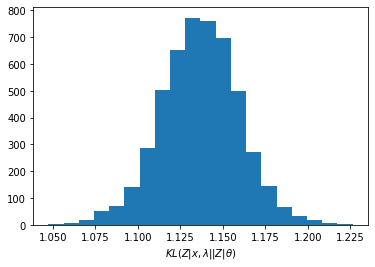

 2. But, marginally, we expect E_X[Z|X] ~ Z E_X[F|X] ~ F and E_FX[Y|F,X] ~ E_F[Y|F].


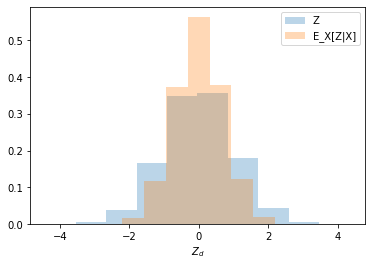

In [26]:
compare_p_q(vae, get_batcher(valid_loader, args), args)

In [27]:
def visualize(vae, batcher: Batcher, args, N=4, num_figs=1): 

    assert N <= args.batch_size, "N should be no bigger than a batch"
    with torch.no_grad():
        vae.p.eval()        
        vae.q.eval()
            
        # Some visualisations
        for r, (x_obs, y_obs) in enumerate(batcher, 1):

            plt.figure(figsize=(2*N, 2*N))
            plt.subplots_adjust(wspace=0.5, hspace=0.5)        
        
            
            # [B, H*W]
            x_obs = x_obs.reshape(-1, args.height * args.width)
            x_obs = x_obs[:N]
            # [B, 10]
            context = None
            
            B, H, K, D = x_obs.shape[0], vae.p.z_dim, vae.p.y_dim, vae.p.data_dim            
            # marginal probability
            prob = vae.estimate_ll_per_bit(x_obs, args.num_samples).exp()            
            # posterior samples
            z, f, y = vae.q.sample(x_obs)
            x = vae.p.X(z=z, y=y).sample()
            # prior samples
            z_, f_, y_, x_ = vae.p.sample((N,))

            for i in range(N):
                plt.subplot(4, N, 0*N + i + 1)
                plt.imshow(x_obs[i].reshape(args.height, args.width).cpu(), cmap='Greys')
                plt.title("$x^{(%d)}$" % (i+1))

                plt.subplot(4, N, 1*N + i + 1)
                plt.imshow(x[i].reshape(args.height, args.width).cpu(), cmap='Greys')
                plt.title("$p(x^{(%d)})$" % (i+1))
                
                plt.subplot(4, N, 2*N + i + 1)                
                #plt.axhline(y=args.height//2, c='red', linewidth=1, ls='--')
                plt.imshow(x[i].reshape(args.height, args.width).cpu(), cmap='Greys')
                plt.title("X,Y,F|$x^{(%d)}$" % (i+1))
                if 0 < vae.p.y_dim <= 10:
                    plt.xlabel(f'f={bitvec2str(f[i])}')
                
                plt.subplot(4, N, 3*N + i + 1)
                plt.imshow(x_[i].reshape(args.height, args.width).cpu(), cmap='Greys')
                plt.title("X,Y,F")
                if 0 < vae.p.y_dim <= 10:
                    plt.xlabel(f'f={bitvec2str(f[i])}')
                
            plt.show()

            if r == num_figs:
                break

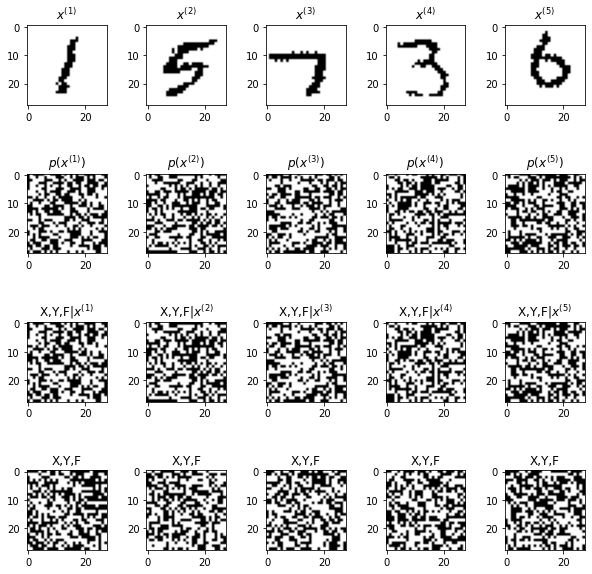

In [28]:
visualize(vae, get_batcher(valid_loader, args), args, N=5)

## Training

In [29]:
from collections import OrderedDict


def validate(vae, batcher, num_samples, compute_DR=False):
    """
    Return average NLL
        average number of bits per dimension
        and a dictionary with distortion and rate estimates
    """
    with torch.no_grad():
        vae.eval()
        
        nb_obs = 0
        nb_bits = 0.
        ll = 0.
        DR = OrderedDict()
        for x_obs, y_obs in batcher:
            # [B, H*W]
            x_obs = x_obs.reshape(-1, vae.p.data_dim)     
            # [B]
            ll = ll + vae.estimate_ll(x_obs, num_samples).sum(0)
            nb_bits += np.prod(x_obs.shape)
            nb_obs += x_obs.shape[0]
            # []
            if compute_DR:
                ret = vae.DR(x_obs)
                for k, v in ret.items():
                    if k not in DR:
                        DR[k] = []
                    DR[k].append(v.cpu().numpy())

    nll = - (ll / nb_obs).cpu()
    if compute_DR:
        DR = OrderedDict((k, np.concatenate(v, 0)) for k, v in DR.items())    
        return nll, nll / np.log(2) / vae.p.latent_dim, DR
    else:
        return nll, nll / np.log(2) / vae.p.latent_dim

In [30]:
from tqdm.auto import tqdm
from itertools import chain
from collections import defaultdict

### Optimiser

In [31]:
p_opt = torch.optim.Adam(p.parameters(), lr=args.gen_lr, weight_decay=args.gen_l2)
q_opt = torch.optim.Adam(q.parameters(), lr=args.inf_lr, weight_decay=args.inf_l2)
stats_tr = defaultdict(list)
stats_val = defaultdict(list)

### Steps

In [32]:
val_metrics = validate(vae, get_batcher(valid_loader, args), args.num_samples)
print(f'Validation {0:3d}: nll={val_metrics[0]:.2f} bpd={val_metrics[1]:.2f}')

Validation   0: nll=542.00 bpd=78.19


In [33]:
for epoch in range(args.epochs):

    iterator = tqdm(get_batcher(train_loader, args))

    for x_obs, y_obs in iterator:        
        # [B, H*W]
        x_obs = x_obs.reshape(-1, args.height * args.width)
        # [B, 10]
        context = None   
        
        vae.train()      
        loss, ret = vae.loss(x_obs)

        for k, v in ret.items():
            stats_tr[k].append(v)
                
        p_opt.zero_grad()
        q_opt.zero_grad()        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(
            chain(vae.gen_parameters(), vae.inf_parameters()), 
            args.grad_clip
        )        
        p_opt.step()
        q_opt.step()
    
        iterator.set_description(f'Epoch {epoch+1:3d}')
        iterator.set_postfix(ret)
    
    val_metrics = validate(vae, get_batcher(valid_loader, args), args.num_samples)
    stats_val['val_nll'].append(val_metrics[0])
    stats_val['val_bpd'].append(val_metrics[1])
    print(f'Validation {epoch+1:3d}: nll={val_metrics[0]:.2f} bpd={val_metrics[1]:.2f}')

  0%|          | 0/275 [00:00<?, ?it/s]

Validation   1: nll=191.60 bpd=27.64


  0%|          | 0/275 [00:00<?, ?it/s]

Validation   2: nll=176.48 bpd=25.46


  0%|          | 0/275 [00:00<?, ?it/s]

Validation   3: nll=153.98 bpd=22.21


  0%|          | 0/275 [00:00<?, ?it/s]

Validation   4: nll=143.97 bpd=20.77


  0%|          | 0/275 [00:00<?, ?it/s]

Validation   5: nll=138.41 bpd=19.97


  0%|          | 0/275 [00:00<?, ?it/s]

Validation   6: nll=134.15 bpd=19.35


  0%|          | 0/275 [00:00<?, ?it/s]

Validation   7: nll=130.57 bpd=18.84


  0%|          | 0/275 [00:00<?, ?it/s]

Validation   8: nll=127.81 bpd=18.44


  0%|          | 0/275 [00:00<?, ?it/s]

Validation   9: nll=125.90 bpd=18.16


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  10: nll=124.46 bpd=17.96


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  11: nll=122.84 bpd=17.72


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  12: nll=121.71 bpd=17.56


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  13: nll=120.63 bpd=17.40


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  14: nll=119.53 bpd=17.24


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  15: nll=118.60 bpd=17.11


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  16: nll=117.96 bpd=17.02


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  17: nll=117.23 bpd=16.91


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  18: nll=116.71 bpd=16.84


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  19: nll=115.97 bpd=16.73


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  20: nll=115.31 bpd=16.64


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  21: nll=114.77 bpd=16.56


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  22: nll=114.41 bpd=16.51


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  23: nll=114.07 bpd=16.46


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  24: nll=113.69 bpd=16.40


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  25: nll=113.28 bpd=16.34


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  26: nll=112.81 bpd=16.28


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  27: nll=112.50 bpd=16.23


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  28: nll=112.53 bpd=16.23


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  29: nll=112.10 bpd=16.17


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  30: nll=111.93 bpd=16.15


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  31: nll=111.40 bpd=16.07


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  32: nll=111.27 bpd=16.05


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  33: nll=110.87 bpd=15.99


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  34: nll=110.68 bpd=15.97


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  35: nll=110.57 bpd=15.95


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  36: nll=110.29 bpd=15.91


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  37: nll=110.31 bpd=15.91


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  38: nll=109.93 bpd=15.86


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  39: nll=109.70 bpd=15.83


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  40: nll=109.59 bpd=15.81


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  41: nll=109.38 bpd=15.78


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  42: nll=109.12 bpd=15.74


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  43: nll=108.92 bpd=15.71


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  44: nll=108.96 bpd=15.72


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  45: nll=108.84 bpd=15.70


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  46: nll=108.58 bpd=15.66


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  47: nll=108.63 bpd=15.67


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  48: nll=108.33 bpd=15.63


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  49: nll=108.14 bpd=15.60


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  50: nll=107.95 bpd=15.57


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  51: nll=107.99 bpd=15.58


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  52: nll=107.82 bpd=15.56


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  53: nll=107.73 bpd=15.54


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  54: nll=107.64 bpd=15.53


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  55: nll=107.46 bpd=15.50


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  56: nll=107.39 bpd=15.49


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  57: nll=107.26 bpd=15.47


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  58: nll=107.05 bpd=15.44


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  59: nll=107.26 bpd=15.47


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  60: nll=107.13 bpd=15.46


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  61: nll=106.76 bpd=15.40


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  62: nll=106.69 bpd=15.39


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  63: nll=106.90 bpd=15.42


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  64: nll=106.67 bpd=15.39


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  65: nll=106.80 bpd=15.41


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  66: nll=106.59 bpd=15.38


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  67: nll=106.55 bpd=15.37


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  68: nll=106.35 bpd=15.34


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  69: nll=106.43 bpd=15.36


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  70: nll=106.14 bpd=15.31


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  71: nll=106.19 bpd=15.32


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  72: nll=106.10 bpd=15.31


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  73: nll=105.81 bpd=15.26


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  74: nll=105.98 bpd=15.29


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  75: nll=106.01 bpd=15.29


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  76: nll=105.90 bpd=15.28


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  77: nll=105.78 bpd=15.26


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  78: nll=105.63 bpd=15.24


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  79: nll=105.46 bpd=15.21


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  80: nll=105.75 bpd=15.26


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  81: nll=105.36 bpd=15.20


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  82: nll=105.48 bpd=15.22


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  83: nll=105.36 bpd=15.20


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  84: nll=105.23 bpd=15.18


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  85: nll=105.27 bpd=15.19


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  86: nll=105.20 bpd=15.18


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  87: nll=105.29 bpd=15.19


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  88: nll=105.18 bpd=15.17


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  89: nll=105.27 bpd=15.19


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  90: nll=105.15 bpd=15.17


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  91: nll=105.20 bpd=15.18


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  92: nll=105.05 bpd=15.16


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  93: nll=105.06 bpd=15.16


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  94: nll=104.78 bpd=15.12


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  95: nll=104.88 bpd=15.13


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  96: nll=104.87 bpd=15.13


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  97: nll=104.77 bpd=15.11


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  98: nll=104.70 bpd=15.10


  0%|          | 0/275 [00:00<?, ?it/s]

Validation  99: nll=104.72 bpd=15.11


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 100: nll=104.70 bpd=15.10


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 101: nll=104.52 bpd=15.08


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 102: nll=104.48 bpd=15.07


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 103: nll=104.52 bpd=15.08


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 104: nll=104.28 bpd=15.04


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 105: nll=104.47 bpd=15.07


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 106: nll=104.37 bpd=15.06


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 107: nll=104.49 bpd=15.07


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 108: nll=104.24 bpd=15.04


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 109: nll=104.29 bpd=15.05


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 110: nll=104.37 bpd=15.06


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 111: nll=104.12 bpd=15.02


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 112: nll=104.11 bpd=15.02


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 113: nll=104.13 bpd=15.02


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 114: nll=104.05 bpd=15.01


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 115: nll=104.11 bpd=15.02


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 116: nll=104.07 bpd=15.01


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 117: nll=104.12 bpd=15.02


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 118: nll=103.89 bpd=14.99


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 119: nll=103.83 bpd=14.98


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 120: nll=104.00 bpd=15.00


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 121: nll=104.02 bpd=15.01


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 122: nll=103.81 bpd=14.98


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 123: nll=103.91 bpd=14.99


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 124: nll=103.91 bpd=14.99


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 125: nll=103.80 bpd=14.98


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 126: nll=103.78 bpd=14.97


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 127: nll=103.73 bpd=14.97


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 128: nll=103.68 bpd=14.96


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 129: nll=103.78 bpd=14.97


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 130: nll=103.54 bpd=14.94


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 131: nll=103.61 bpd=14.95


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 132: nll=103.58 bpd=14.94


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 133: nll=103.55 bpd=14.94


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 134: nll=103.59 bpd=14.95


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 135: nll=103.43 bpd=14.92


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 136: nll=103.65 bpd=14.95


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 137: nll=103.58 bpd=14.94


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 138: nll=103.51 bpd=14.93


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 139: nll=103.45 bpd=14.92


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 140: nll=103.45 bpd=14.92


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 141: nll=103.29 bpd=14.90


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 142: nll=103.29 bpd=14.90


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 143: nll=103.42 bpd=14.92


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 144: nll=103.06 bpd=14.87


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 145: nll=103.43 bpd=14.92


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 146: nll=103.31 bpd=14.90


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 147: nll=103.45 bpd=14.92


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 148: nll=103.05 bpd=14.87


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 149: nll=103.06 bpd=14.87


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 150: nll=103.26 bpd=14.90


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 151: nll=103.12 bpd=14.88


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 152: nll=103.08 bpd=14.87


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 153: nll=103.22 bpd=14.89


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 154: nll=103.09 bpd=14.87


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 155: nll=102.92 bpd=14.85


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 156: nll=103.05 bpd=14.87


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 157: nll=102.98 bpd=14.86


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 158: nll=102.85 bpd=14.84


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 159: nll=102.96 bpd=14.85


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 160: nll=102.84 bpd=14.84


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 161: nll=102.88 bpd=14.84


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 162: nll=102.87 bpd=14.84


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 163: nll=102.70 bpd=14.82


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 164: nll=103.07 bpd=14.87


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 165: nll=102.81 bpd=14.83


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 166: nll=102.93 bpd=14.85


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 167: nll=102.68 bpd=14.81


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 168: nll=102.96 bpd=14.85


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 169: nll=102.80 bpd=14.83


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 170: nll=102.61 bpd=14.80


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 171: nll=102.83 bpd=14.83


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 172: nll=102.71 bpd=14.82


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 173: nll=102.69 bpd=14.81


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 174: nll=102.86 bpd=14.84


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 175: nll=102.79 bpd=14.83


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 176: nll=102.87 bpd=14.84


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 177: nll=102.64 bpd=14.81


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 178: nll=102.75 bpd=14.82


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 179: nll=102.89 bpd=14.84


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 180: nll=102.51 bpd=14.79


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 181: nll=102.70 bpd=14.82


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 182: nll=102.76 bpd=14.82


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 183: nll=102.64 bpd=14.81


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 184: nll=102.59 bpd=14.80


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 185: nll=102.69 bpd=14.82


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 186: nll=102.59 bpd=14.80


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 187: nll=102.81 bpd=14.83


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 188: nll=102.42 bpd=14.78


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 189: nll=102.47 bpd=14.78


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 190: nll=102.55 bpd=14.80


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 191: nll=102.55 bpd=14.79


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 192: nll=102.73 bpd=14.82


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 193: nll=102.39 bpd=14.77


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 194: nll=102.44 bpd=14.78


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 195: nll=102.28 bpd=14.76


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 196: nll=102.56 bpd=14.80


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 197: nll=102.35 bpd=14.77


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 198: nll=102.50 bpd=14.79


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 199: nll=102.30 bpd=14.76


  0%|          | 0/275 [00:00<?, ?it/s]

Validation 200: nll=102.39 bpd=14.77


### Training Curves

In [34]:
np_stats_tr = {k: np.array(v) for k, v in stats_tr.items()}
np_stats_val = {k: np.array(v) for k, v in stats_val.items()}

In [35]:
def smooth(v, kernel_size=100):
    if kernel_size is None:
        return v
    return np.convolve(v, np.ones(kernel_size)/kernel_size, 'valid')

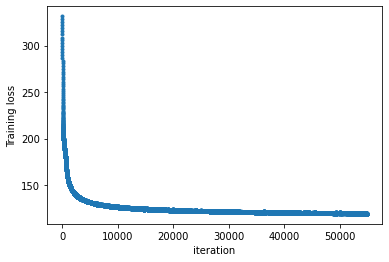

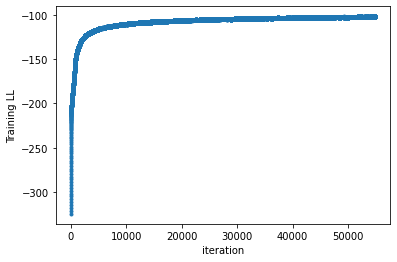

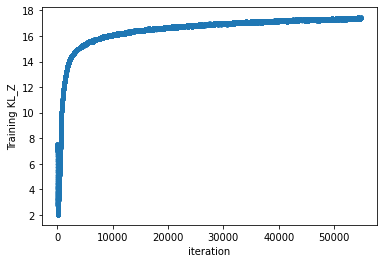

In [36]:
for k, v in np_stats_tr.items():
    v = smooth(v)
    plt.plot(np.arange(1, v.size + 1), v, '.')    
    plt.ylabel(f'Training {k}')
    plt.xlabel('iteration')
    plt.show()

### Validation Curves

In [37]:
from tabulate import tabulate

print(tabulate(
    [(k, np.mean(v[-100:]), np.min(v[-100:])) for k, v in np_stats_val.items()],
    headers=['metric', 'mean', 'min']
))

metric        mean       min
--------  --------  --------
val_nll   103.271   102.283
val_bpd    14.8989   14.7563


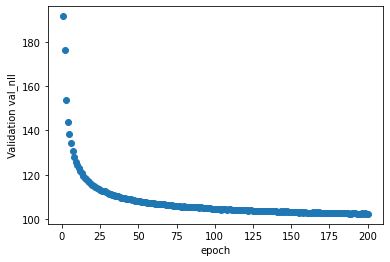

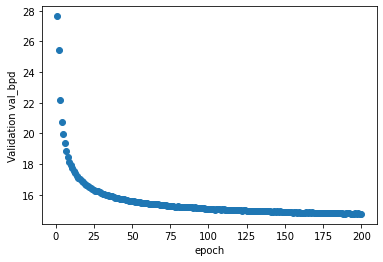

In [38]:
for k, v in np_stats_val.items():    
    plt.plot(np.arange(1, v.size + 1), v, 'o')
    plt.ylabel(f'Validation {k}')
    plt.xlabel('epoch')
    plt.show()

In [39]:
val_nll, val_bpd, val_DR = validate(
    vae, get_batcher(valid_loader, args), args.num_samples, compute_DR=True)

In [46]:
rows = [('IS-NLL', val_nll, None), ('IS-BPD', val_bpd, None)]
for k, v in val_DR.items():
    rows.append((k, v.mean(), v.std()))
print(tabulate(rows, headers=['metric', 'mean', 'std']))    

metric        mean       std
--------  --------  --------
IS-NLL    102.367
IS-BPD     14.7685
D          88.5055  29.1935
R          17.4076   1.83976
R_Z        17.4076   1.83976
R_F         0        0
R_Y         0        0


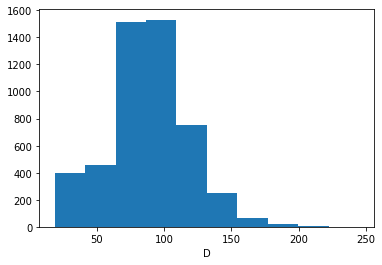

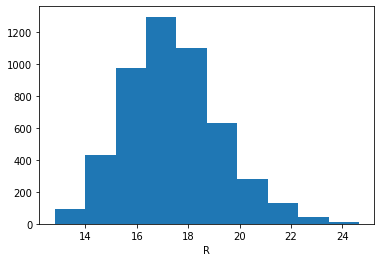

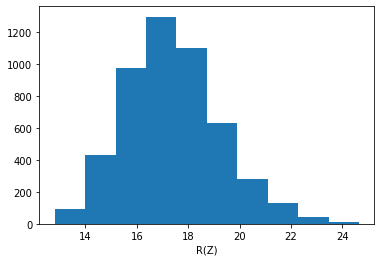

In [41]:
_ = plt.hist(val_DR['D'])
_ = plt.xlabel('D')
plt.show()

_ = plt.hist(val_DR['R'])
_ = plt.xlabel('R')
plt.show()

if vae.p.z_dim:
    _ = plt.hist(val_DR['R_Z'])
    _ = plt.xlabel('R(Z)')
    plt.show()
    
if vae.p.y_dim:
    _ = plt.hist(val_DR['R_F'])
    _ = plt.xlabel('R(F)')
    plt.show()

    _ = plt.hist(val_DR['R_Y'])
    _ = plt.xlabel('R(Y|F)')
    plt.show()

### Analysis

For a trained VAE: 
 1. We want to see that KL(Z|x || Z), KL(F|x || F), and KL(Y|f,x || Y|f) are generally > 0 for any x ~ D.


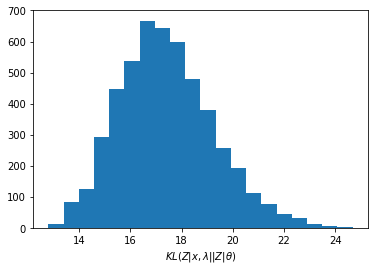

 2. But, marginally, we expect E_X[Z|X] ~ Z E_X[F|X] ~ F and E_FX[Y|F,X] ~ E_F[Y|F].


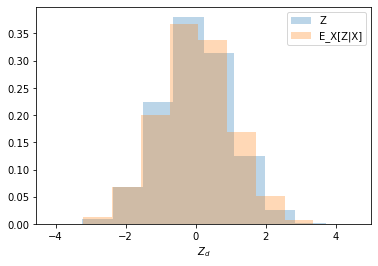

In [42]:
compare_p_q(vae, get_batcher(valid_loader, args), args)

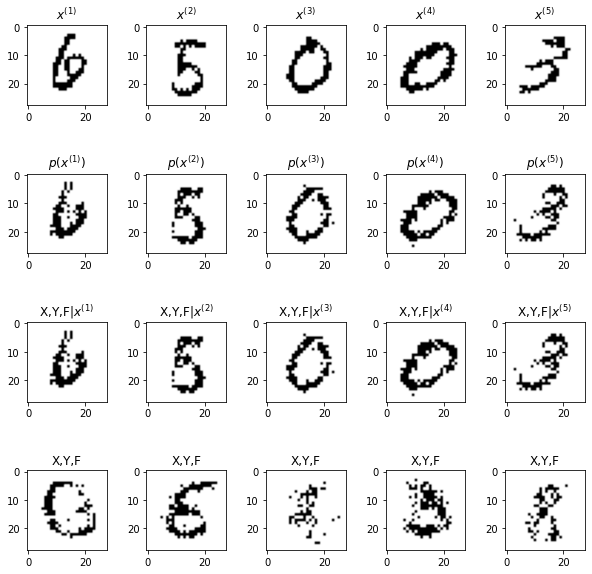

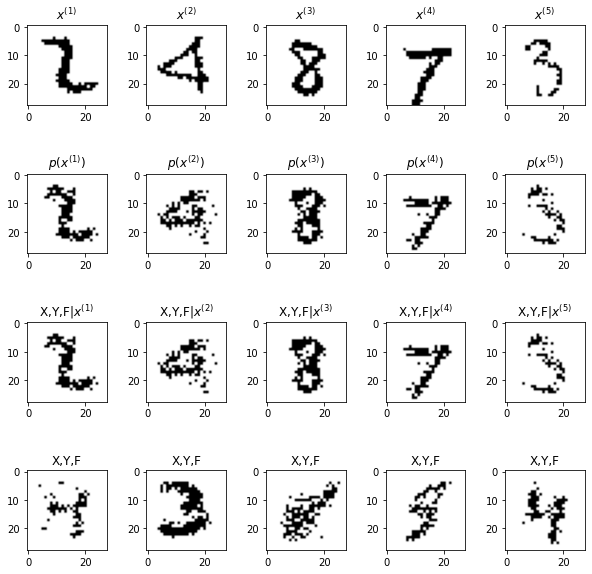

In [43]:
visualize(vae, get_batcher(valid_loader, args), args, N=5, num_figs=2)